# The Semantic Detective: Anomaly Detection with Vector Search

In the vast and noisy world of cybersecurity, traditional keyword searches and rule-based systems often fail to detect novel threats. This project moves beyond these brittle methods to build an intelligent, context-aware anomaly detection system for the BETH cybersecurity dataset[1].

### Problem Statement

Security analysts are often overwhelmed by millions of cryptic host process logs. The challenge is to automatically identify malicious activities, including novel "zero-day" attacks, that don't match known patterns. Standard methods are too rigid and fail to understand the underlying *intent* of an action, making them easy for attackers to evade.

### Our Approach: The Semantic Detective 🕵️‍♀️

We are tackling this problem using **Approach 2: The Semantic Detective**. Our mission is to go beyond keyword matching and uncover deep, semantic relationships in the log data using **BigQuery's native vector search**. By building a system that understands meaning and context, we can identify anomalous activities with incredible accuracy.

Our implementation will leverage the BigFrames library to seamlessly perform these key operations:
* `bigframes.ml.llm.TextEmbeddingGenerator()`: To convert log narratives into meaningful vectors.
* `bigframes.bigquery.create_vector_index()`: To build a high-speed search index.
* `bigframes.bigquery.vector_search()`: To find anomalous events by querying the index.

### Impact Statement

This solution provides a scalable and future-proof framework for threat hunting. By identifying anomalies based on semantic meaning, it can detect novel attacks that would be missed by traditional systems. The result is a significant reduction in missed threats (False Negatives) and a more efficient workflow for security analysts, allowing them to focus on the most genuinely suspicious activities.

**Note:** To reproduce the following results download and store the BETH dataset[1] under the "./BETH/beth-dataset" path. The dataset could be found at https://www.kaggle.com/datasets/katehighnam/beth-dataset

#### 1. Setup: Importing the Toolkit
First, we need to import all the necessary libraries for our investigation. This includes:

bigframes: The core library for interacting with BigQuery using a pandas-like API and accessing its powerful machine learning features.

sklearn: A fundamental machine learning library we'll use for tasks like dimensionality reduction (TSNE) and evaluating our findings.

pandas and numpy: The standard toolset for data manipulation and numerical operations in Python.

matplotlib and seaborn: For visualizing our high-dimensional data and results, which is crucial for interpreting the model's behavior.

In [1]:
import bigframes
import bigframes.pandas as bpd
from bigframes.ml.llm import TextEmbeddingGenerator
import bigframes.bigquery as bq

import pandas as pd
import json

import numpy as np
import math

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

import os

import matplotlib.pyplot as plt
import seaborn as sns

import ast

## 1. Setup: Importing Our Toolkit 

We'll start by importing the essential Python libraries for this project. These tools will handle everything from large-scale data processing in BigQuery to machine learning and visualization.

* **`bigframes`**: The core library for interacting with BigQuery using a pandas-like API and accessing its powerful machine learning features.
* **`sklearn`**: A fundamental machine learning library we'll use for tasks like dimensionality reduction (`TSNE`) and evaluating our findings.
* **`pandas` and `numpy`**: The standard toolset for data manipulation and numerical operations.
* **`matplotlib` and `seaborn`**: Key libraries for visualizing our high-dimensional data, which is crucial for interpreting the model's behavior.

In [ ]:
# BigQuery connection details
project_id = 'playexch-80b6'
#table_id = f'{project_id}.{table_name}'
data_location = 'US'

DATASET_ID = 'ePBF_samples'
TEXT_EMBEDDING_TABLE_ID = 'external_ePBF_with_embeddings'

# Set environment variables for the session
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id
os.environ['GRPC_DNS_RESOLVER'] = 'native'

# Configure the backend for generative AI models
os.environ['GOOGLE_CLOUD_LOCATION']= 'global'
os.environ['GOOGLE_GENAI_USE_VERTEXAI']='True'

# Allow BigFrames to handle large query results without size limitations
bpd.options.bigquery.allow_large_results = True

## 3. Data Loading and Validation

We'll begin by loading the BETH dataset, which is distributed across multiple local CSV files. To ensure data integrity and prevent downstream errors, we'll perform a crucial validation step. Before loading the full content of any file, we will first inspect its header to confirm that it contains all the expected columns.

In [ ]:
# Path to the local directory containing the BETH dataset CSVs
directory_path = 'BETH/beth-dataset'

# Define the set of columns we expect to find in each valid CSV file
required_columns = {
    'timestamp', 'processId', 'parentProcessId', 'userId', 'processName',
    'hostName', 'eventId', 'eventName', 'argsNum', 'returnValue', 'args',
    'sus', 'evil'
}

list_of_dataframes = []

# Loop through all files in the specified directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        try:
            # Efficiently read only the header to check columns without loading the whole file
            df_header = pd.read_csv(file_path, nrows=0) 
            
            # Check if the file contains all the columns we need
            if required_columns.issubset(df_header.columns):

                df = pd.read_csv(file_path)
                list_of_dataframes.append(df)
                print(f"Appended data from: {filename}")
            else:
                print(f"Skipped {filename}: Missing one or more required columns.")
        
        except pd.errors.EmptyDataError:
            print(f"Skipped {filename}: File is empty.")
        except Exception as e:
            print(f"An error occurred with {filename}: {e}")

Appended data from: labelled_2021may-ip-10-100-1-4.csv
Skipped labelled_2021may-ubuntu-dns.csv: Missing one or more required columns.
Appended data from: labelled_2021may-ubuntu.csv
Skipped labelled_2021may-ip-10-100-1-186-dns.csv: Missing one or more required columns.
Skipped labelled_2021may-ip-10-100-1-4-dns.csv: Missing one or more required columns.
Appended data from: labelled_2021may-ip-10-100-1-186.csv
Appended data from: labelled_training_data.csv
Skipped labelled_2021may-ip-10-100-1-95-dns.csv: Missing one or more required columns.
Appended data from: labelled_2021may-ip-10-100-1-26.csv
Skipped labelled_2021may-ip-10-100-1-105-dns.csv: Missing one or more required columns.
Appended data from: labelled_2021may-ip-10-100-1-95.csv
Skipped labelled_2021may-ip-10-100-1-26-dns.csv: Missing one or more required columns.
Appended data from: labelled_testing_data.csv
Appended data from: labelled_validation_data.csv
Appended data from: labelled_2021may-ip-10-100-1-105.csv


The next step is to combine these individual DataFrames into a single, unified dataset.

In [5]:
combined_df = pd.concat(list_of_dataframes, ignore_index=True)

combined_df.shape

(3807196, 16)

We have ~ 4 Million records that allign with our validation of expected columns

## 4. Data Preprocessing: Unpacking Process Arguments

A key feature for understanding any system event is the set of arguments passed to a process. In this dataset, that information is in the `args` column, but it's stored as a complex, string-formatted list of dictionaries.

To make this data useful for our embedding model, we need to parse this string into a clean, readable format. The function below is designed for this task, with several key features:

* **Safety**: It uses `ast.literal_eval()` to safely parse the string without the security risks associated with a full `eval()`.
* **Formatting**: It transforms the nested data into a clean, comma-separated `key=value` summary, which is ideal for both human readability and machine learning.
* **Robustness**: It handles malformed data gracefully, returning the original string if parsing fails, which prevents errors in our data pipeline.

In [ ]:
def parse_and_format_args(arg_string):
    """
    Safely parses the argument string and formats it into a clean key=value summary.
    """
    if not isinstance(arg_string, str) or not arg_string.startswith('['):
        return arg_string # Return as-is if not a string or not list-like

    try:
        # Safely evaluate the string into a Python object (a list of dicts)
        arg_list = ast.literal_eval(arg_string)


        if isinstance(arg_list, list) and len(arg_list) > 0:
            inner_list = arg_list[0]
            if isinstance(inner_list, list):
                arg_list = inner_list

        # Format into "key=value" pairs
        if isinstance(arg_list, list):
            # Use .get() for safety in case 'name' or 'value' keys are missing
            formatted_args = [f"{arg.get('name', 'arg')}={arg.get('value', 'N/A')}" for arg in arg_list]
            return ', '.join(formatted_args)
        else:
            return arg_string # Return original if structure is unexpected
            
    except (ValueError, SyntaxError, MemoryError):
        # If parsing fails for any reason, just return the original string
        return arg_string


## 5. Feature Engineering: Crafting an Event Narrative

The success of our vector search hinges on the quality of the input text. Simply concatenating raw data columns would fail to provide the context our embedding model needs to be effective.

Our solution is to perform **feature engineering**. For each system event, we will construct a detailed, human-readable sentence, or "narrative." This narrative will serve as the input for our `TextEmbeddingGenerator` and is built by intelligently weaving together multiple data points to capture the event's full story.

### The Anatomy of an Event Narrative

Each narrative is constructed from several key components:

* **The Core Action**: Who did what, and with what parameters?
    > *e.g., Process 'sshd' (PID: 123) performed a 'connect' action with details: [fd=4, path=/run/systemd]...*

* **The Outcome**: Did the action succeed or fail? The numerical `returnValue` is translated into a plain English description of the result.

* **The Execution Context**: Where did the event occur? We check the `mountNamespace` to determine if the process ran on the main host or inside a container—a crucial detail for security analysis.

* **The Origin**: How was the action initiated? The `stackAddresses` are included to provide a deep technical trace of the event's source.

By combining these elements, we create a rich description that gives the language model a deep, contextual understanding of each event.

In [ ]:
def create_final_embedding_text(df):
    """
    Generates a highly contextual and clean text sentence for each event to be used for embedding.
    """
    def generate_row_text(row):
        # 1. Get the clean, formatted arguments from our previously defined function
        clean_args = parse_and_format_args(row['args'])

        # 2. Translate the numerical returnValue into a human-readable outcome
        try:
            ret_val = int(float(row['returnValue']))
            if ret_val == 0:
                outcome = f"succeeded (return value: {ret_val})"
            elif ret_val < 0:
                outcome = f"failed with an error code (return value: {ret_val})"
            else:
                outcome = f"completed, returning a resource handle or ID (return value: {ret_val})"
        except (ValueError, TypeError):
            outcome = f"returned a non-numeric value ('{row['returnValue']}')"

        # 3. Build the core narrative sentence using an f-string for clarity
        text = (
            f"Process '{row['processName']}' (PID: {row['processId']}), spawned by parent PID {row['parentProcessId']}, "
            f"performed a '{row['eventName']}' action with details: [{clean_args}]. "
            f"This operation {outcome}."
        )

        # 4. Add optional context if the data is available
        if pd.notna(row['threadId']) and int(row['threadId']) != -1:
            text += f" Execution was handled by thread {int(row['threadId'])}."

        # A key piece of domain-specific feature engineering: Is this in a container?
        if pd.notna(row['mountNamespace']) and int(row['mountNamespace']) != -1:
            namespace_id = int(row['mountNamespace'])
            # The namespace ID 4026531841 corresponds to the host in many Linux systems.
            # Higher values often indicate sandboxed or containerized environments.
            env_context = "in a containerized sandbox" if namespace_id > 4026531841 else "on the main host system"
            text += f" The process operated {env_context} (namespace ID: {namespace_id})."

        # 5. Add stack trace for deep technical context
        if row['stackAddresses'] != 'N/A':
            text += f" The action originated from the call trace: {row['stackAddresses']}."

        return text

    # --- Data Cleaning within the function ---
    # Before generating the text, ensure there are no missing values that could cause errors.
    key_cols = [
        'processName', 'eventName', 'args', 'returnValue', 'stackAddresses',
        'processId', 'parentProcessId', 'threadId', 'mountNamespace'
    ]
    for col in key_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('N/A')
        else:
            df[col] = df[col].fillna(-1) # Use -1 as a sentinel value for numeric types

    # Apply the narrative generation function to every row in the DataFrame
    df['embedding_text'] = df.apply(generate_row_text, axis=1)
    return df

## 6. Applying Feature Engineering and Deduplication

Now we'll process the combined dataset by generating the event narratives and then optimizing the result by removing duplicates. This creates a clean and efficient dataset for the embedding model.

1.  **Generate the Narrative**: We first apply the `create_final_embedding_text` function to produce the `embedding_text` column. This column contains the rich, contextual narrative for each unique system event.

2.  **Deduplicate for Efficiency**: System logs are highly repetitive. Generating embeddings for identical text is inefficient and adds no informational value. Therefore, we identify and remove all rows with a duplicate `embedding_text`. This is a crucial optimization that preserves every unique behavior while significantly reducing the dataset's size and the subsequent cost of generating embeddings.

In [8]:
combined_df = create_final_embedding_text(combined_df)
print(f'Number of rows with non-unique embedding text, {combined_df['embedding_text'].duplicated().sum()} records')

Number of rows with non-unique embedding text, 1735169 records


In [9]:
deduped_df = combined_df.drop_duplicates(subset=['embedding_text'])

deduped_df.shape

(2072027, 17)

The output shows that a substantial number of events in the original dataset were duplicates, which is common for system logs. After removing these, we are left with approximately 2.07 million unique event narratives.

In [10]:
deduped_df.to_csv('/Users/jeffreysam/pvotal_git/eBPF-Vector-Index/BETH/combined_df.csv')

In [13]:
BETH_df = pd.read_csv('BETH/combined_df.csv')

BETH_df.to_gbq(f"{DATASET_ID}.BETH_df", if_exists='replace')

/var/folders/vf/yvx5wh2s7k9bhxgwzz7ccsvh0000gn/T/ipykernel_4695/3687382444.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  BETH_df = pd.read_csv('BETH/combined_df.csv')
/var/folders/vf/yvx5wh2s7k9bhxgwzz7ccsvh0000gn/T/ipykernel_4695/3687382444.py:3: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  BETH_df.to_gbq(f"{DATASET_ID}.BETH_df", if_exists='replace')
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNI

This deduplicated dataset is now optimized for the next stage. By saving it to a CSV, and uploading it to BigQuery. The next step is to upload this processed text data and begin generating the vector embeddings using an embedding model

## 7. Splitting the Data: Preparing for Evaluation

To fairly evaluate our system's performance, we'll split the dataset into two parts: one for building our index and another for testing it.

* **Training Set (`train_df`)**: This set, comprising 90% of the data, will be used to generate embeddings and build our vector index. Our system learns the patterns of normal and malicious behavior from this data.

* **Test Set (`test_df`)**: This is a 10% held-out portion of data that the system will not see during the build process. We'll use it at the very end to simulate performance on new, unseen events.

Crucially, we'll perform a **stratified split** based on the `evil` column. This technique ensures that the proportion of malicious events is identical in both the training and test sets. This step is vital for an unbiased evaluation, especially in cybersecurity where attack events can be rare.

In [16]:
train_df, test_df = train_test_split(
    BETH_df,
    test_size=0.1,
    stratify=BETH_df['evil'],
    random_state=42  
)

In [17]:
train_df.duplicated().sum(), test_df.duplicated().sum(), BETH_df.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

Here, we are just ensuring that our data has no duplicates.

In [22]:
BETH_df['embedding_text'].duplicated().sum()

np.int64(0)

## 8. Model Selection: Choosing the Embedding Engine

The core of our system is the embedding model, which converts our text narratives into numerical vectors for semantic search. The quality of these vectors is critical, and we've selected Google's **`gemini-embedding-001`** for this task.

This model is a strong choice for several key reasons:

* **High Dimensionality**: It generates vectors with **3072 dimensions**, allowing it to capture complex and nuanced relationships within our detailed log data. This is crucial for distinguishing between subtly different system behaviors.

* **Cost-Effectiveness**: At approximately **$0.15 per 1 million tokens**, it's an affordable choice for embedding our large dataset, making large-scale analysis feasible.

* **Sufficient Context Window**: The model supports an input of **2048 tokens**, which comfortably accommodates our rich but concise event narratives.

In summary, `gemini-embedding-001` offers an excellent balance of performance, cost, and practical efficiency for our project's needs.

In [24]:
embedding_model = TextEmbeddingGenerator(model_name='gemini-embedding-001')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/ml/llm.py:656: DefaultLocationWarning: No explicit location is set, so using location US for the session.
  self.session = session or global_session.get_global_session()
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/ml/llm.py:673: UserWarning: Model name 'gemini-embedding-001' is not supported. We are currently aware of the following models: text-embedding-005, text-embedding-004, text-multilingual-embedding-002. However, model names can change, and the supported models may be outdated. You should use this model name only if you are sure that it is supported in BigQuery.
  warnings.warn(msg)


## 9. Generating Embeddings: Translating Text to Vectors

This is the most critical and computationally intensive step in our project. We'll now use the `.predict()` method of our `gemini-embedding-001` model to convert each text narrative in our training data into a **3072-dimension numerical vector**.

This vector mathematically captures the semantic meaning of each event's narrative. As this process involves making a network call to the embedding service for each unique text entry, it is the most time-consuming part of our pipeline.

In [25]:
train_embeddings_df = embedding_model.predict(train_df['embedding_text'])

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/array_value.py:114: PreviewWarning: Interpreting JSON column(s) as the `db_dtypes.dbjson` extension type isin preview; this behavior may change in future versions.
  warnings.warn(msg, bfe.PreviewWarning)


Execution Time: 137m 29.5s

As expected, this operation took over two hours to complete. This runtime is a direct result of processing millions of unique text entries and is the primary computational cost of this approach. The benefit of using BigFrames is that it handles the complex batching and parallelization of these calls to the Vertex AI backend automatically.

The result is a new DataFrame, train_embeddings_df, which contains our original text alongside a new column named text_embedding. This column holds the powerful 3072-dimension vectors. With these vectors in hand, we are now ready to build an index that will allow us to perform similarity searches almost instantaneously.

In [26]:
train_embeddings_df.columns

Index(['ml_generate_embedding_result', 'ml_generate_embedding_statistics',
       'ml_generate_embedding_status', 'content'],
      dtype='object')

## 10. Data Integration: Combining Embeddings with Labels

Now that the vector embeddings are generated, we need to re-join them with their original `sus` and `evil` ground truth labels. This integration is essential for the subsequent analysis and indexing stages.

This housekeeping process involves a few simple steps:

1.  **Extract Labels**: We select the `sus` and `evil` columns from the original training DataFrame.
2.  **Concatenate**: We perform a column-wise merge to combine the embeddings with their corresponding labels.
3.  **Rename & Reorder**: Finally, we rename the columns for better clarity and reorder them into a clean, final structure.

In [27]:
labels_df = train_df[['sus', 'evil']]

labels_df = bpd.DataFrame(labels_df)

train_embeddings_df = bpd.concat([train_embeddings_df, labels_df], axis=1)

train_embeddings_df = train_embeddings_df.rename(columns={'ml_generate_embedding_result': 'train_embedding', 'sus':'train_sus', 'evil':'train_evil', 'content':'train_content'})

train_embeddings_df = train_embeddings_df[['train_content', 'train_embedding', 'train_sus', 'train_evil']]

train_embeddings_df.head(2)

,train_content,train_embedding,train_sus,train_evil
0,"Process 'systemd-resolve' (PID: 382), spawned ...",[ 0.00621203 0.00469972 0.02161683 ... -0.00...,0,0
1,"Process 'systemd-resolve' (PID: 382), spawned ...",[ 0.00670247 0.00015451 0.01071928 ... -0.00...,0,0


Here, we push our 'train_embeddings_df' to BigQuery for safekeeping

In [29]:
train_embeddings_df.to_gbq(f"{DATASET_ID}.BETH_train_embeddings", if_exists='replace')

'ePBF_samples.BETH_train_embeddings'

## 11. Embedding Analysis: Validating Vector Quality

With our vector embeddings generated, we can now address a critical question: has the model learned to effectively distinguish between benign and malicious activity? This section will analyze the structure and quality of our high-dimensional vectors to validate their effectiveness.

For computational efficiency, all analysis in this section will be performed on a random sample of **50,000** data points.

### Part 1: Cluster Separation with the Silhouette Score

Our first test is a quantitative one using the **Silhouette Score**. This metric measures how well-defined clusters are by comparing a data point's similarity to its own cluster versus neighboring clusters.

The score ranges from -1 to +1 and is interpreted as follows:

* **Near +1**: Indicates dense, well-separated clusters.
* **Near 0**: Indicates overlapping clusters.
* **Near -1**: Indicates that points may have been assigned to the wrong cluster.

For this test, we'll treat all benign (`evil=0`) and malicious (`evil=1`) events as two distinct clusters. A positive score will provide quantitative evidence that our embedding model has learned to semantically separate these two groups.

In [105]:
sample_size = 50000


sample_df = train_embeddings_df.sample(n=sample_size).to_pandas()

X = np.stack(sample_df['train_embedding'].values)

labels = sample_df['train_evil'].values

score = silhouette_score(X, labels, metric='cosine')

print(f'The Silhouette score for the sample is  {score:.4f}')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extma

The Silhouette score for the sample is  0.3647


A score of **0.3647** is a promising result. It's a positive value well above zero, which indicates that there is a measurable and meaningful separation between the benign and malicious event clusters in the high-dimensional vector space. While the clusters are not perfectly distinct (a score closer to 1.0), this confirms that our feature engineering and the gemini-embedding-001 model have successfully captured a semantic signal that separates normal from attack behavior.

While this number is a good indicator, it doesn't let us see the structure. In the next step, we'll use t-SNE to visualize these clusters.

### Part 2: Visualizing Embeddings with t-SNE

While the Silhouette Score provides a single metric, a visualization offers a more intuitive understanding of our data's structure. For this, we'll use **t-SNE (t-Distributed Stochastic Neighbor Embedding)**, a powerful technique for visualizing high-dimensional data.

t-SNE projects our 3072-dimensional vectors down to a 2D plot while attempting to preserve the local structure. This means events that are semantically similar in the high-dimensional space should appear close together in the visualization. Our goal is to visually confirm if malicious "Attack" events form distinct clusters, separate from the normal, benign events.

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

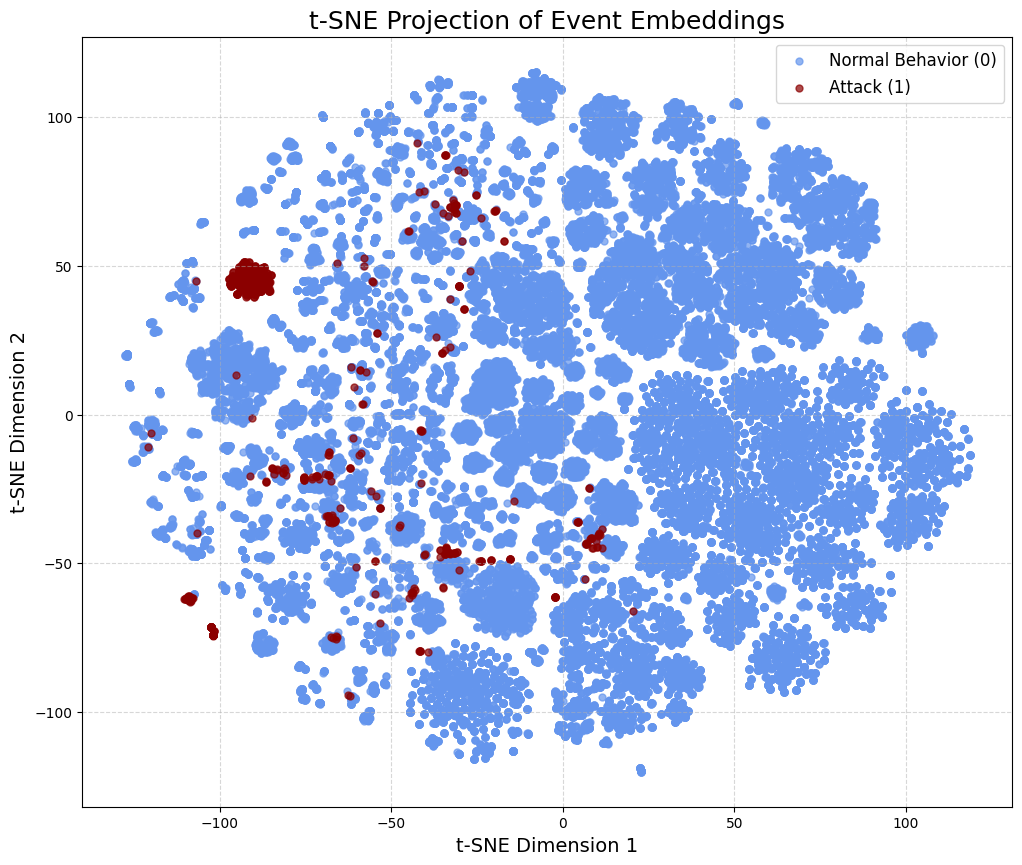

In [107]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(X)

normal_mask = (labels == 0)
attack_mask = (labels == 1)


plt.figure(figsize=(12, 10))

plt.scatter(
    embeddings_2d[normal_mask, 0],
    embeddings_2d[normal_mask, 1],
    c='cornflowerblue',           
    label='Normal Behavior (0)',  
    alpha=0.7,                    
    s=25                          
)


plt.scatter(
    embeddings_2d[attack_mask, 0],
    embeddings_2d[attack_mask, 1],
    c='darkred',                  
    label='Attack (1)',           
    alpha=0.7,
    s=25
)

plt.title('t-SNE Projection of Event Embeddings', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### Interpreting the t-SNE Plot

The visualization provides several key insights that strongly validate our semantic approach:

* **Clear Attack Clusters**: Malicious events (red dots) are not randomly scattered. Instead, they form several small, dense, and distinct clusters. This is a powerful finding, indicating that different attack types have unique semantic signatures that our model has successfully learned to group together.

* **Diverse Normal Behavior**: Benign events (blue dots) form a large, sprawling "continent," as expected. "Normal" system behavior is highly varied and thus occupies a much larger and more diverse area of the semantic space.

* **Validation for Vector Search**: The existence of these tight attack clusters is precisely what makes vector search effective. A search for the "nearest neighbors" of a single malicious event is highly likely to return other events from the same attack cluster, enabling powerful anomaly detection.

This visual evidence confirms that our embeddings have created a meaningful map of system behavior. Next, we'll use this map to examine the structure of events labeled as "suspicious."

### Part 3: Visualizing "Suspicious" Events

The BETH dataset includes a `sus` label for events that are suspicious but not confirmed attacks. To understand the nature of these ambiguous events, we'll use the same t-SNE projection as before, but this time we will highlight the "suspicious" data points.

The key question is: do these events form tight clusters like the malicious attacks, or are they more scattered and heterogeneous?

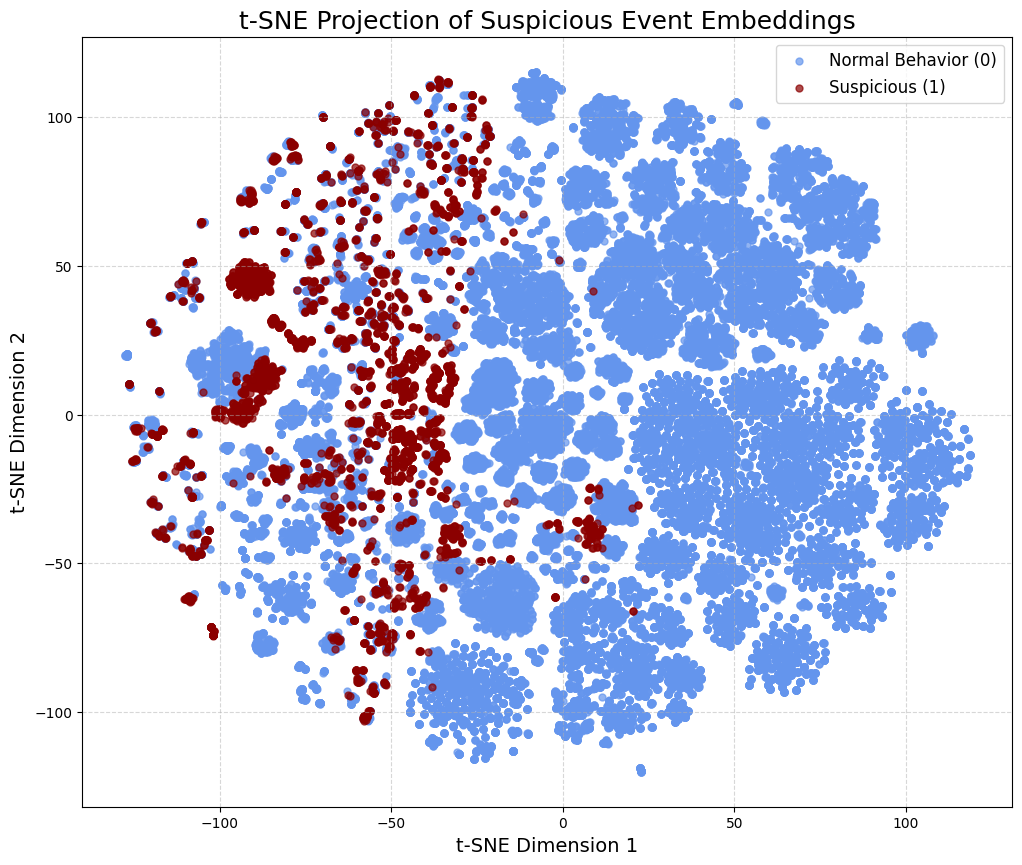

In [108]:
labels = sample_df['train_sus'].values


normal_mask = (labels == 0)
sus_mask = (labels == 1)


plt.figure(figsize=(12, 10))

plt.scatter(
    embeddings_2d[normal_mask, 0],
    embeddings_2d[normal_mask, 1],
    c='cornflowerblue',           
    label='Normal Behavior (0)',  
    alpha=0.7,                    
    s=25                          
)


plt.scatter(
    embeddings_2d[sus_mask, 0],
    embeddings_2d[sus_mask, 1],
    c='darkred',                  
    label='Suspicious (1)',           
    alpha=0.7,
    s=25
)

plt.title('t-SNE Projection of Suspicious Event Embeddings', fontsize=18)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### Interpreting the "Suspicious" Plot

This visualization reveals a very different pattern for "suspicious" events when compared to the confirmed attacks:

* **Scattered and Heterogeneous**: Unlike the tight, distinct clusters of `evil` events, the `suspicious` events are far more widely scattered. While some loose groupings exist, many points are intermingled with normal behavior.

* **Ambiguous Nature**: This visual confirms that "suspicious" is not a single, uniform category. The label likely covers a wide range of unrelated behaviors, from benign-but-uncommon system activity to genuine, low-level threats that lack a clear attack signature.

* **Implications for Detection**: This result shows that a simple search for "suspicious things" would be ineffective. However, it also highlights the power of our approach. Vector search can be used to find ***new***, dense clusters within this sea of suspicious events, potentially identifying novel threats that warrant investigation.

---

Now that we have a visual understanding of our embeddings, our final analysis step is to quantitatively test their predictive power with a K-Nearest Neighbors classifier.

### Part 4: Quantitative Evaluation with K-Nearest Neighbors (KNN)

Our final analysis step is to quantitatively test the predictive power of our embeddings using a **K-Nearest Neighbors (KNN)** classifier. The KNN algorithm's mechanism—classifying a point based on the labels of its closest neighbors—serves as a direct proxy for vector search. Strong KNN performance will therefore validate that our semantic approach is effective for identifying threats.

This experiment has two primary goals:

1.  **Measure Predictive Performance**: We'll use the **F1-Score**, a robust metric that balances precision and recall, making it ideal for imbalanced cybersecurity datasets.

2.  **Determine the Optimal `k`**: We will find the optimal number of neighbors (`k`) to consider. This result will directly inform how many neighbors we should retrieve in our final vector search implementation for the best performance.

Finding optimal k...


Testing k values:   0%|          | 0/15 [00:00<?, ?it/s]

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/sklearn/utils/extma

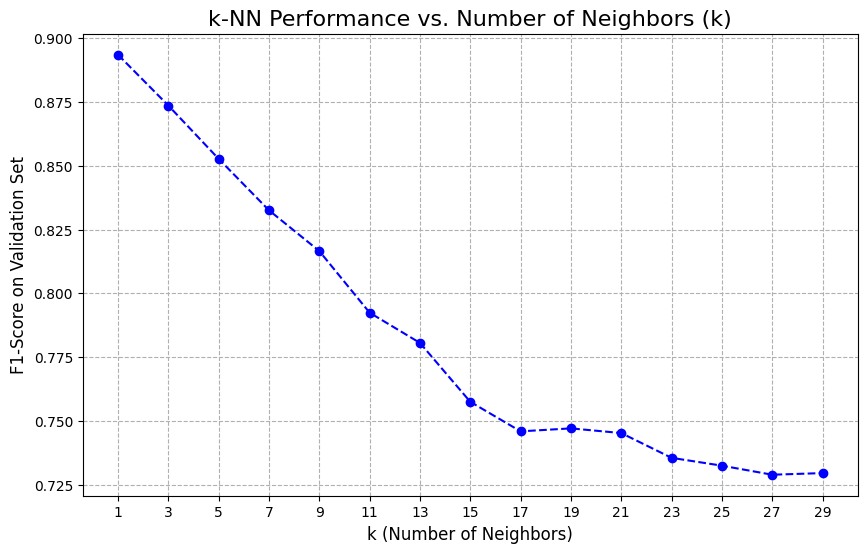

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(
    X, labels, test_size=0.3, random_state=42, stratify=labels
)


k_values = range(1, 31, 2)
f1_scores = []


for k in tqdm(k_values, desc="Testing k values"):
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_val)
    
    score = f1_score(y_val, y_pred)
    f1_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o', linestyle='--', color='b')
plt.title('k-NN Performance vs. Number of Neighbors (k)', fontsize=16)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('F1-Score on Validation Set', fontsize=12)
plt.xticks(k_values)
plt.grid(True, linestyle='--')
plt.show()

### Interpreting the Performance Curve

The plot clearly shows that the highest F1-Score is achieved with **`k=1`**. The score consistently decreases as more neighbors are considered, which strongly indicates that the single closest neighbor is the most powerful predictor of a malicious event.

However, while `k=1` yields the best score in this specific test, a model that relies on a single neighbor can be sensitive to noise and individual outliers, making it less robust.

And if we were to go by the elbow method, **`k=17`** seems to be the inflection point. But we have a significant detoriation in F1-score.

For our final vector search, we will therefore proceed with **`k=5`**. This value still provides a very high F1-Score while giving us a more stable set of neighbors to analyze. Crucially, using `k=5` enables more advanced evaluation strategies, such as the **majority voting** we will explore later, striking an excellent balance between peak performance and practical reliability.

## 12. Building the Vector Index for Ultra-Fast Search

With our embeddings generated, we need an efficient way to search through them. A brute-force search, which compares a query vector to every other vector in our dataset, is too slow for millions of entries.

The solution is to build a **vector index**. This is a specialized data structure that pre-organizes the vectors to enable incredibly fast **Approximate Nearest Neighbor (ANN)** searches. Much like a book's index allows you to find a topic without reading every page, a vector index lets us find the most similar events almost instantly.

We will create the index on our `train_embedding` column with these key parameters:

* **`distance_type='cosine'`**: We'll use cosine similarity to measure the angle between vectors. This aligns with our previous analysis and is ideal for finding semantically similar events.

* **`index_type='tree_ah'`**: This specifies the "Tree with Asymmetric Hashing" algorithm, one of BigQuery’s advanced indexing methods that balances search speed and accuracy.

In [ ]:
# Before creating the index, we first need to save our embeddings DataFrame to a BigQuery table.
train_embeddings_df = bpd.read_gbq(f"{DATASET_ID}.BETH_train_embeddings")

In [35]:
bq.create_vector_index(
    table_id = f"{DATASET_ID}.BETH_train_embeddings",
    column_name ='train_embedding',
    replace = True,
    index_name = 'BETH_train',
    distance_type='cosine',
    index_type = 'tree_ah',
)

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/bigquery/_operations/search.py:89: UserWarning: Reading cached table from 2025-09-18 03:32:41.761288+00:00 to avoid incompatibilies with previous reads of this table. To read the latest version, set `use_cache=False` or close the current session with Session.close() or bigframes.pandas.close_session().
  read_gbq_query(sql)


**Execution Time: 5.6s**

This result is remarkable. Creating a sophisticated search index on over two million 3072-dimension vectors took less than 6 seconds. This showcases the incredible efficiency and power of BigQuery's managed vector search capabilities. The complex process of building and optimizing the index is handled entirely by the service.

With our index BETH_train now built and ready, we can move to the final and most exciting part of our project: using the index to perform semantic searches on new, unseen data from our test set.

In [ ]:
# Rename test set columns for clarity and to prevent conflicts

test_df = test_df.rename(columns = {'embedding_text': 'test_embedding_text', 'sus': 'test_sus', 'evil': 'test_evil'})

In [ ]:
# Create a clean BigFrames DataFrame with just the necessary test data

test_bq_filtered = bpd.DataFrame(test_df[['test_embedding_text', 'test_sus', 'test_evil']])

In [ ]:
# Use the same embedding model to generate vectors for our test set narratives.
# These will be our "query" vectors.

test_search_query = bpd.DataFrame(embedding_model.predict(test_bq_filtered['test_embedding_text']))

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/array_value.py:114: PreviewWarning: Interpreting JSON column(s) as the `db_dtypes.dbjson` extension type isin preview; this behavior may change in future versions.
  warnings.warn(msg, bfe.PreviewWarning)


## 14. Preparing the Final Test DataFrame

Before executing our final search, we need to perform one last data preparation step. We will integrate the newly generated test embeddings with their original ground truth labels (`test_sus` and `test_evil`).

This crucial housekeeping step creates a single, clean DataFrame containing both the query vector and its true labels. This will simplify the final evaluation, as we'll be able to directly compare the labels of the search results to the true label of the query itself.

In [46]:
labels_df_test = test_df[['test_sus', 'test_evil']]

labels_df_test = bpd.DataFrame(labels_df_test)

test_embeddings_df = bpd.concat([test_search_query, labels_df_test], axis=1)

test_embeddings_df = test_embeddings_df.rename(columns={'ml_generate_embedding_result': 'test_embedding', 'content':'test_content'})

test_embeddings_df = test_embeddings_df[['test_content', 'test_embedding', 'test_sus', 'test_evil']]

test_embeddings_df.head(2)


,test_content,test_embedding,test_sus,test_evil
27,"Process 'sshd' (PID: 1281), spawned by parent ...",[-0.00856535 0.01030297 0.00975739 ... 0.01...,0,0
37,"Process 'sshd' (PID: 7308), spawned by parent ...",[ 0.00840416 0.0177378 0.00254029 ... 0.01...,1,0


The output table confirms our test DataFrame is now perfectly assembled. Each row contains the test event's narrative, its query vector, and its true labels.

All the pieces are in place. The index is built, and the queries are prepared. We are now ready to execute the vector search.

## Executing the Vector Search

With our index built and queries prepared, we can now execute the final search. For each query vector in our unseen test set, the `bq.vector_search()` function will find the most semantically similar events from our indexed training data.

For each of the thousands of test events, the function will:

1.  Take the event's query vector.
2.  Use our `BETH_train` index to efficiently scan through millions of indexed vectors.
3.  Return the **top 5** most similar events from the training data, based on cosine similarity.

This is the core operation of our "Semantic Detective," putting all our feature engineering, embedding, and indexing work to the final test.

In [52]:
test_vector_search_results = bq.vector_search(
                 base_table=f"{DATASET_ID}.BETH_train_embeddings",
                 column_to_search="train_embedding",
                 query=test_embeddings_df,
                 distance_type="COSINE",
                 query_column_to_search="test_embedding",
                 top_k=5)

### Results and Next Steps

The search operation returns a new DataFrame, `test_vector_search_results`. This table links each test event to its **5 closest neighbors** from the training set and includes the similarity score (`distance`) for each match.

This results table is the foundation for our final evaluation, where we will:

* **Make Predictions**: Create a prediction for each test event based on the labels of its neighbors (e.g., using a majority vote or the single nearest neighbor).

* **Evaluate Performance**: Compare these predictions to the true `test_evil` labels to calculate definitive performance metrics like **F1-Score, Precision, Recall,** and plot a **Confusion Matrix**.

This quantitative analysis will provide the final proof of how effectively our semantic search system can identify malicious activity in new, unseen data.

## 16. Inspecting the Search Results

With the search now complete, we'll perform a few high-level checks on the raw results. This initial inspection will help us understand the quality of the matches found by our index before we proceed to the full quantitative evaluation.

In [ ]:
# Display the top 5 rows of the results table

test_vector_search_results.head()

,test_content,test_embedding,test_sus,test_evil,train_content,train_embedding,train_sus,train_evil,distance
108139,"Process 'ps' (PID: 7581), spawned by parent PI...",[ 0.02364101 -0.00104114 0.00458344 ... 0.01...,0,0,"Process 'ps' (PID: 7581), spawned by parent PI...",[ 0.0260999 -0.00616 -0.00051746 ... 0.01...,0,0,0.016866
840987,"Process 'ps' (PID: 7374), spawned by parent PI...",[ 0.01474492 0.00849905 0.010908 ... 0.00...,0,0,"Process 'ps' (PID: 7374), spawned by parent PI...",[ 0.01994072 0.00850128 0.00905249 ... 0.01...,0,0,0.025759
1902193,"Process 'ps' (PID: 7526), spawned by parent PI...",[ 0.00726963 -0.00308563 0.01931601 ... 0.00...,0,0,"Process 'ps' (PID: 7526), spawned by parent PI...",[ 0.00928064 -0.00464632 0.01931471 ... -0.00...,0,0,0.007941
149159,"Process 'sshd' (PID: 7750), spawned by parent ...",[ 0.0263264 0.02111565 -0.0045742 ... -0.00...,1,0,"Process 'sshd' (PID: 7750), spawned by parent ...",[ 0.02331815 0.01796781 0.00079607 ... -0.00...,1,0,0.022556
481578,"Process 'sshd' (PID: 8031), spawned by parent ...",[ 0.01080905 0.01936683 0.00457475 ... -0.00...,0,0,"Process 'sshd' (PID: 8403), spawned by parent ...",[ 0.00891507 0.01522678 0.01429774 ... -0.00...,0,0,0.035112


In [54]:
test_vector_search_results['distance'].mean()

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


np.float64(0.012996392583870156)

**Extremely High Similarity:** The average cosine distance between our test queries and their nearest neighbors is ~0.013. Since a cosine distance of 0 represents a perfect semantic match, this extremely low average distance is a strong quantitative sign of success. It means our system is consistently finding events in the training data that are semantically almost identical to our unseen test events.

In [55]:
test_vector_search_results[test_vector_search_results['distance']==0.0].shape

(0, 9)

**No Duplicates:** The check for zero-distance matches confirms that our test set was truly "unseen" by the index. Our system is not just finding duplicates; it is finding genuinely new events that are contextually similar to what it has seen before.

In [57]:
test_vector_search_results.to_gbq(f"{DATASET_ID}.test_vector_search_results_k5", if_exists='replace')

'ePBF_samples.test_vector_search_results_k5'

In [ ]:
test_vector_search_results = bpd.read_gbq(f"{DATASET_ID}.test_vector_search_results_k5")

# Sanity check for shape
test_vector_search_results.shape

(1036015, 9)

## 17. Evaluation Framework: Defining Our Metrics

To properly evaluate our "Semantic Detective," we must look beyond simple accuracy. In cybersecurity, the cost of a missed detection (a False Negative) is often far more severe than that of a false alarm (a False Positive). Therefore, we require a more nuanced set of metrics.

The helper function below, `calculate_and_plot_metrics`, provides a standardized way to assess our results by calculating and displaying the following:

* **Precision**: When the model predicts an attack, how often is it correct? This measures the rate of false alarms.
* **Recall**: Of all the actual attacks, how many did the model successfully identify? This measures the rate of missed detections.
* **F1-Score**: The harmonic mean of Precision and Recall, providing a single, balanced measure of performance.
* **MCC (Matthews Correlation Coefficient)**: A particularly reliable metric for imbalanced datasets, as it accounts for all four values in the confusion matrix.
* **Confusion Matrix**: A visual grid that clearly breaks down where the model is making correct and incorrect predictions.

In [11]:
def calculate_and_plot_metrics(tp, tn, fp, fn, plot_matrix=True, title_prefix=""):
    """
    Calculates and prints key classification metrics and optionally plots a confusion matrix.

    This function uses robust data types to prevent overflow and formatting errors.

    Args:
        tp (int): True Positives.
        tn (int): True Negatives.
        fp (int): False Positives.
        fn (int): False Negatives.
        plot_matrix (bool): If True, plots the confusion matrix. Defaults to True.
        title_prefix (str): A prefix for the plot title, e.g., "'evil' Predictions".
    """
    # Use a stable float type for calculations to prevent overflow
    tp_f, tn_f, fp_f, fn_f = np.float64(tp), np.float64(tn), np.float64(fp), np.float64(fn)

    # Accuracy
    accuracy = (tp_f + tn_f) / (tp_f + tn_f + fp_f + fn_f) if (tp_f + tn_f + fp_f + fn_f) > 0 else 0

    # Precision
    precision = tp_f / (tp_f + fp_f) if (tp_f + fp_f) > 0 else 0

    # Recall (Sensitivity)
    recall = tp_f / (tp_f + fn_f) if (tp_f + fn_f) > 0 else 0

    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Matthews Correlation Coefficient (MCC)
    mcc_denom = np.sqrt((tp_f + fp_f) * (tp_f + fn_f) * (tn_f + fp_f) * (tn_f + fn_f))
    mcc = ((tp_f * tn_f) - (fp_f * fn_f)) / mcc_denom if mcc_denom > 0 else 0


    print(f"--- {title_prefix} Classification Metrics ---")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1-Score:    {f1_score:.4f}")
    print(f"MCC:         {mcc:.4f}\n")


    if plot_matrix:
        # For plotting, we use the original integer counts
        conf_matrix = np.array([[tn, fp],
                                [fn, tp]])

        plt.figure(figsize=(7, 5))
        # 'coolwarm' is a standard red-blue gradient suitable for imbalanced data
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    cbar=False, annot_kws={"size": 14})

        plt.title(f'{title_prefix} Confusion Matrix', fontsize=16, pad=20)
        plt.ylabel('Actual Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        tick_labels = ['Negative (0)', 'Positive (1)']
        plt.xticks(ticks=[0.5, 1.5], labels=tick_labels)
        plt.yticks(ticks=[0.5, 1.5], labels=tick_labels, rotation=0, va="center")
        plt.show()

In [12]:
results_table_id = f"{DATASET_ID}.test_vector_search_results_k5"

We need to count the number of True Positives, True Negatives, False Positives, and False Negatives. We can do this efficiently with a single SQL query directly in BigQuery. The query below compares the actual label of each test event with the label of its nearest neighbor to tally the results for both the evil and sus classifications.

In [13]:
metrics_query = f"""
    SELECT
      -- Metrics for the 'evil' column
      COUNTIF(test_evil = 1 AND train_evil = 1) AS tp_evil,
      COUNTIF(test_evil = 0 AND train_evil = 0) AS tn_evil,
      COUNTIF(test_evil = 0 AND train_evil = 1) AS fp_evil,
      COUNTIF(test_evil = 1 AND train_evil = 0) AS fn_evil,

      -- Metrics for the 'sus' column
      COUNTIF(test_sus = 1 AND train_sus = 1) AS tp_sus,
      COUNTIF(test_sus = 0 AND train_sus = 0) AS tn_sus,
      COUNTIF(test_sus = 0 AND train_sus = 1) AS fp_sus,
      COUNTIF(test_sus = 1 AND train_sus = 0) AS fn_sus
    FROM
      `{results_table_id}`
"""
metrics_df = bpd.read_gbq_query(metrics_query)

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/jeffreysam/primary_env/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


--- Attack Classification Metrics ---
Accuracy:    0.9994
Precision:   0.9824
Recall:      0.9759
F1-Score:    0.9791
MCC:         0.9788



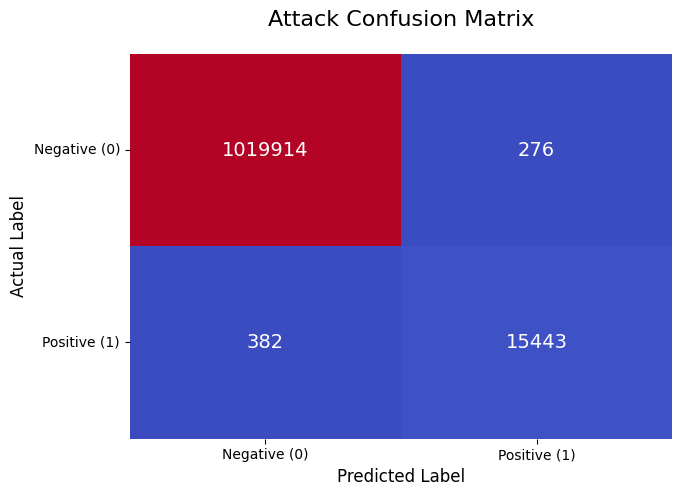

In [114]:
tp_evil = metrics_df['tp_evil'].iloc[0]
tn_evil = metrics_df['tn_evil'].iloc[0]
fp_evil = metrics_df['fp_evil'].iloc[0]
fn_evil = metrics_df['fn_evil'].iloc[0]

calculate_and_plot_metrics(tp=tp_evil, tn=tn_evil, fp=fp_evil, fn=fn_evil, plot_matrix=True, title_prefix='Attack')

### Analysis of Attack Detection Performance 

The performance metrics demonstrate an exceptionally effective detection system.

* A **Precision of 98.24%** means that when the system flags an event as an attack, it is correct over 98% of the time. This extremely low rate of false alarms (`276` events) is critical for security operations, ensuring analyst time is focused on legitimate threats.

* A **Recall of 97.59%** indicates that the system successfully identified nearly 98% of all actual attacks in the test data. The low number of missed attacks (`382`) demonstrates comprehensive threat coverage.

* The high **F1-Score and MCC (~0.98)** confirm an excellent and robust balance between precision and recall, with the MCC score being particularly significant given the dataset's class imbalance.

* The **confusion matrix** visually reinforces this success, showing the vast majority of predictions falling on the main diagonal (correct classifications) with minimal errors.

### Performance on Ambiguous Signals: "Suspicious" Events

Next, we'll evaluate the system's performance on the more challenging and ambiguous `suspicious` category. These events are not confirmed attacks but represent unusual system behavior.

A strong performance here would demonstrate the model's ability to generalize beyond known attack patterns and identify potentially novel or low-level threats.

--- Suspicious Classification Metrics ---
Accuracy:    0.9902
Precision:   0.9580
Recall:      0.9396
F1-Score:    0.9487
MCC:         0.9433



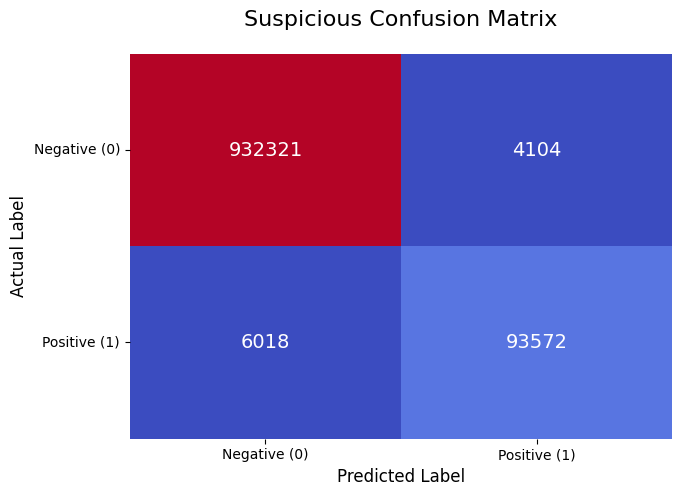

In [115]:
tp_sus = metrics_df['tp_sus'].iloc[0]
tn_sus = metrics_df['tn_sus'].iloc[0]
fp_sus = metrics_df['fp_sus'].iloc[0]
fn_sus = metrics_df['fn_sus'].iloc[0]


calculate_and_plot_metrics(tp=tp_sus, tn=tn_sus, fp=fp_sus, fn=fn_sus, plot_matrix=True, title_prefix='Suspicious')

### Analysis of Suspicious Event Detection

The results for detecting "suspicious" events are also excellent and provide a final, compelling validation of our approach.

* **Strong, Yet Nuanced, Performance**: The key metrics (**Precision ~96%, Recall ~94%**) are extremely high. As expected, they are slightly lower than the near-perfect scores for the clear-cut `evil` category, which reflects the inherent ambiguity of "suspicious" behavior.

* **Consistency with Visual Analysis**: This outcome aligns perfectly with our t-SNE visualizations. The `evil` events formed tight, isolated clusters, enabling precise classification. In contrast, the `sus` events were more scattered and semantically diverse, which naturally results in a slightly lower, yet still powerful, predictive performance.

The fact that the system performs so well even on this "fuzzy" category is a powerful testament to the semantic approach. It proves the model is not just memorizing known attack signatures but is genuinely understanding the context of system behavior, allowing it to effectively classify both clear-cut threats and more nuanced activities.

## 18. A More Robust Strategy: Majority Voting Evaluation

While using the single nearest neighbor is effective, a more robust approach is to take a **majority vote** from all 5 of the neighbors we retrieved. The final prediction for a test event will be based on the most common label within its neighborhood, making the system less sensitive to any single outlier.

The code below implements this strategy by:

1.  Grouping the search results by each unique test event.
2.  Calculating the `mean` of the neighbors' `train_evil` labels. For 0/1 data, a mean of `0.6` (3/5) or higher signifies that the majority of neighbors were malicious.
3.  Assigning a final prediction based on this majority vote.
4.  Calculating the performance metrics using this new, more robust set of predictions.

In [18]:
test_vector_search_results_grouped = test_vector_search_results.groupby('test_embedding')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Aggregrate Classification Metrics ---
Accuracy:    0.9996
Precision:   0.9930
Recall:      0.9804
F1-Score:    0.9866
MCC:         0.9865



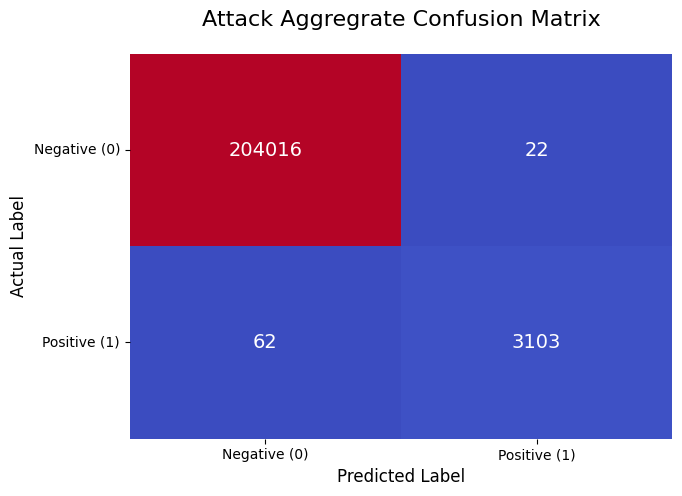

In [19]:
majority_votes_evil_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean'
})


majority_votes_evil_df['predicted_evil'] = (majority_votes_evil_df['train_evil'] >= 0.6).astype("Int64")

y_true = majority_votes_evil_df['test_evil']
y_pred = majority_votes_evil_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()




calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Attack Aggregrate')

### Analysis of Majority Vote Performance

The results show that the majority vote strategy is a significant improvement over the baseline naive approach, confirming the value of this more robust method.

* **Improved Metrics**: Both key metrics improved significantly. **Precision** increased from 98.24% to **99.30%**, and **Recall** increased from 97.59% to **98.04%**.

* **Drastic Error Reduction**: The confusion matrix clearly shows this impact. **False Positives** (false alarms) plummeted from 276 to just **22**, while **False Negatives** (missed attacks) dropped from 382 to **62**.

* **The "Wisdom of the Crowd"**: This improvement occurs because a single misleading neighbor is often outvoted by the other correct neighbors. This leads to a more stable and accurate final prediction, making the system more reliable.

This confirms that for this dataset, a  majority vote is the optimal strategy, delivering a detection system with near-perfect precision and recall.

## 19. Fine-Tuning the Threshold: Prioritizing Recall

This experiment addresses a common operational need in cybersecurity: what if minimizing missed attacks (maximizing **Recall**) is the top priority? We can achieve this by making our system more sensitive.

To do this, we will adjust the prediction threshold of our majority vote. Instead of requiring a strict majority (3/5 votes), we will now flag an event as malicious if just **2 out of 5** of its neighbors are malicious (a threshold of `0.4`). This demonstrates the classic **precision-recall tradeoff**: we expect to catch more real threats, likely at the cost of creating more false alarms.

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Aggregrate(evil>=0.4) Classification Metrics ---
Accuracy:    0.9995
Precision:   0.9824
Recall:      0.9870
F1-Score:    0.9847
MCC:         0.9845



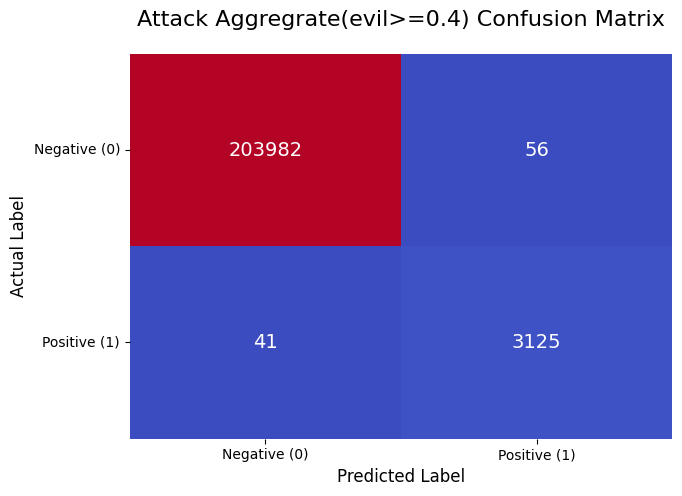

In [20]:
majority_votes_evil_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean'
})


majority_votes_evil_df['predicted_evil'] = (majority_votes_evil_df['train_evil'] >= 0.4).astype("Int64")

y_true = majority_votes_evil_df['test_evil']
y_pred = majority_votes_evil_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()




calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Attack Aggregrate(evil>=0.4)')

### Analysis of the Tuned Threshold

As intended, adjusting the threshold successfully tuned the model's behavior, perfectly illustrating the classic precision-recall tradeoff.

* **Recall Increased**: By lowering the threshold, Recall improved from 98.04% to **98.70%**. This successfully reduced the number of missed attacks (False Negatives) from 62 to just **41**.

* **Precision Decreased**: As expected, this came at a cost. Precision dropped slightly from 99.30% to **98.25%**, and the number of false alarms (False Positives) increased from 22 to **56**.

---
### The Strategic Decision: Tuning for the Mission

This result highlights a key advantage of our approach: the "best" threshold is not a single number but a strategic choice based on operational needs.

* **High-Precision Model (Threshold `≥ 0.6`)**: Ideal for an understaffed security team where every alert must be a high-confidence signal to prevent "alert fatigue."

* **High-Recall Model (Threshold `≥ 0.4`)**: Ideal for a critical environment where missing even one threat is unacceptable, and the team has the resources to investigate a slightly higher number of false alarms.

This demonstrates that the system can be flexibly tuned to meet the specific risk tolerance and operational capacity of any security team.

## The Maximum Sensitivity Strategy

This strategy represents a **zero-tolerance** approach to threat detection, designed to achieve the highest possible recall.

* **Rationale**: The core logic is that if an unknown event is semantically similar to even a *single* known malicious event, it is too risky to ignore and must be flagged for investigation.

* **Goal**: To maximize **Recall** and minimize the number of **False Negatives** (missed threats) as much as possible.

* **The Tradeoff**: The expected cost of this high sensitivity is a decrease in **Precision**, which will lead to a higher number of **False Positives** (false alarms).

* **Implementation**: This is achieved by setting the prediction threshold to `0.2`. This correctly triggers an alert if just **1 out of 5** neighbors is malicious (`1/5 = 0.2`).

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Aggregrate(evil>=0.2) Classification Metrics ---
Accuracy:    0.9990
Precision:   0.9431
Recall:      0.9946
F1-Score:    0.9682
MCC:         0.9680



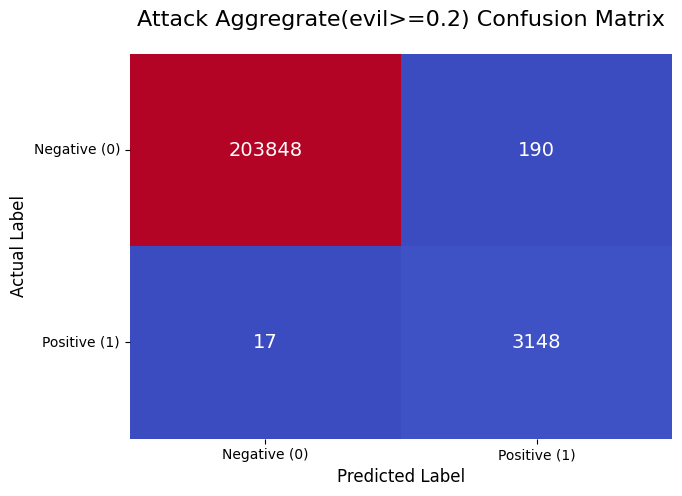

In [25]:
majority_votes_evil_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean'
})


majority_votes_evil_df['predicted_evil'] = (majority_votes_evil_df['train_evil'] >= 0.2).astype("Int64")

y_true = majority_votes_evil_df['test_evil']
y_pred = majority_votes_evil_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()




calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Attack Aggregrate(evil>=0.2)')

### Analysis of the Maximum Sensitivity Strategy

The results confirm that making the model extremely sensitive successfully optimized for recall.

* **Near-Perfect Recall**: The primary goal was achieved, with **Recall** increasing to a phenomenal **99.46%**. This means the system now catches virtually every malicious attack in the test set.

* **Drastic Reduction in Missed Attacks**: As a direct result, the number of **False Negatives** (missed attacks) plummeted to an incredibly low **17**, the main benefit of this high-sensitivity approach.

* **The Expected Tradeoff**: This heightened sensitivity came at the expected cost of lower precision. **Precision** dropped to **94.31%**, as the number of **False Positives** (false alarms) increased to **190**. While still a strong precision score, this represents the necessary tradeoff for maximizing threat detection.

## A Hybrid Strategy: Combining "Evil" and "Suspicious" Signals 

This final experiment tests a more complex, hybrid strategy. The rationale is that a strong cluster of `suspicious` neighbors could be a valuable, independent signal of a threat, even if no neighbor is explicitly labeled `evil`.

Therefore, our new prediction rule is a compound condition:

> An event is flagged as an attack if **EITHER** at least one of its five nearest neighbors is a confirmed attack (`evil ≥ 0.2`) **OR** if a strong majority (three of five) of its neighbors are suspicious (`sus ≥ 0.6`).

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Predictions (Evil >= 0.2 OR Sus >= 0.6) Classification Metrics ---
Accuracy:    0.9205
Precision:   0.1608
Recall:      0.9972
F1-Score:    0.2770
MCC:         0.3839



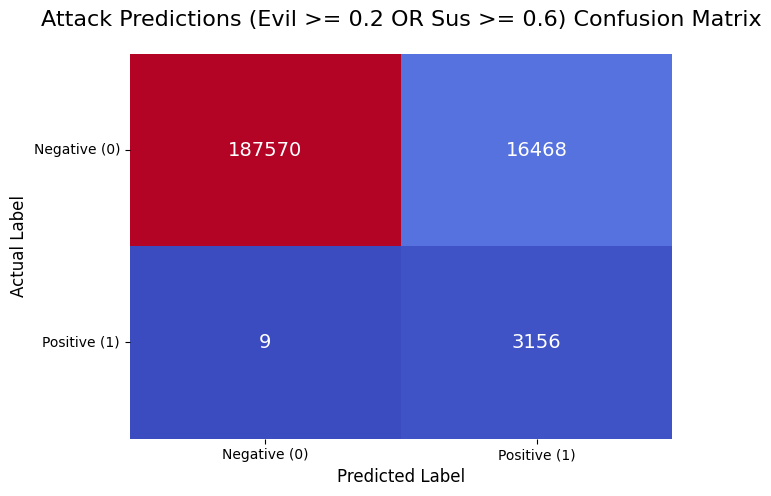

In [23]:
majority_votes_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean',
    'train_sus': 'mean',
})


evil_condition = (majority_votes_df['train_evil'] >= 0.2)
sus_condition = (majority_votes_df['train_sus'] >= 0.6)

majority_votes_df['predicted_evil'] = (evil_condition | sus_condition).astype("Int64")


y_true = majority_votes_df['test_evil']
y_pred = majority_votes_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()


calculate_and_plot_metrics(
    tp=tp, tn=tn, fp=fp, fn=fn,
    plot_matrix=True,
    title_prefix="Attack Predictions (Evil >= 0.2 OR Sus >= 0.6)"
)

### Analysis of the Hybrid Strategy

This hybrid strategy dramatically alters the model's behavior, pushing it to the far end of the precision-recall spectrum.

* **Near-Perfect Recall**: The primary goal was a success. **Recall** soared to **99.72%**, and the number of **False Negatives** (missed attacks) plummeted to a remarkable **9**. This represents the most comprehensive threat detection level achieved.

* **Collapsed Precision**: This near-perfect recall came at a severe cost. **Precision** collapsed to just **16.08%**, as the number of **False Positives** (false alarms) exploded to over 16,000. In practical terms, this means roughly 84 out of every 100 alerts generated by this model would be benign.

* **The Underlying Cause**: This outcome was predictable from our t-SNE analysis. We saw that the `suspicious` label overlaps significantly with normal data. By incorporating this "noisy" signal into our prediction, we inevitably flagged thousands of benign events that reside in suspicious-looking neighborhoods of the vector space.

## Evaluation Conclusion: A Tunable System for Advanced Threat Detection

Our evaluation explored five distinct prediction strategies, moving from a simple baseline to more complex, tuned models. This final analysis summarizes their performance and recommends an ideal configuration for the primary cybersecurity objective: minimizing missed threats.

### Summary of Strategies

The performance of each strategy is summarized below, showcasing the tradeoff between precision and recall.

| Strategy Name | Prediction Rule | Precision | Recall | False Negatives (Missed Attacks) | Ideal Use Case |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1. Baseline (k=1)** | Label of 1st neighbor | 0.9824 | 0.9759 | 382 | A simple and effective starting point. |
| **2. Strict Majority** | `≥ 3/5` evil votes | **0.9930** | 0.9804 | 62 | **High-Precision Alerter**: Generates the fewest false alarms, ideal for automation. |
| **3. Loose Majority** | `≥ 2/5` evil votes | 0.9825 | 0.9870 | 41 | A balanced model with excellent recall and high precision. |
| **4. Maximum Sensitivity** | `≥ 1/5` evil votes | 0.9431 | **0.9946** | **17** | **High-Recall Detector**: Catches the maximum number of threats with a manageable increase in noise. |
| **5. Hybrid "Dragnet"** | `≥ 1/5` evil OR `≥ 3/5` sus | 0.1608 | **0.9972** | **9** | **Threat Hunting Tool**: A specialized "dragnet" for expert analysts to ensure nothing is missed. |

### The Verdict: Recommending the Optimal Strategy

For our primary goal—a security system where **failing to detect a real attack (a False Negative) is the most critical error**—the **Maximum Sensitivity (Strategy #4)** is the ideal configuration.

This strategy reduces the number of missed attacks to an exceptionally low **17**, achieving a recall of **99.46%**. Crucially, it accomplishes this while maintaining a very high precision of over **94%**. This represents an excellent tradeoff, providing a significant boost in threat detection with only a minimal and manageable increase in false alarms.

### A Flexible Framework for Any Security Team

While the "Maximum Sensitivity" model is our recommended choice, this evaluation demonstrates the system's greatest strength: **flexibility**. The table provides a clear menu of options that can be tailored to a security team's specific needs and resources. A team overwhelmed by alerts could deploy the "Strict Majority" model for its high-confidence notifications, while a dedicated threat hunting team could use the "Hybrid Model" to generate leads for deep-dive investigations.

In [ ]:
""" 


Strategy                     Prediction Rule	          Precision	    Recall	    False Negatives
1. Baseline	                    All neighbours	          0.9824	    0.9759	    382
2. Strict Majo                  ≥ 3/5 evil votes	      0.993	        0.9804	    62
3. Loose Majority	            ≥ 2/5 evil votes	      0.9825	    0.987	    41
4. Maximum Sensitivity	        ≥ 1/5 evil votes	      0.9431	    0.9946	    17
5. Hybrid Model	                ≥ 1/5 evil OR ≥ 3/5 sus	  0.1608	    0.9972	    9
 
 
 """

# Project Summary & Final Conclusion 

This project embarked on a mission to move beyond traditional cybersecurity methods and build an intelligent, context-aware threat detection system. Starting with millions of raw, cryptic log entries from the BETH dataset, we successfully engineered a sophisticated "Semantic Detective" capable of understanding the *meaning* behind system behavior to identify malicious and anomalous activity with remarkable accuracy.

---

### Our Three-Step Transformation

Our approach was a clear departure from brittle, rule-based systems. We transformed chaotic data into actionable intelligence through a three-step process:

1.  **Narrative Engineering**: We first translated complex log data into rich, human-readable narratives. Each sentence captured the full context of an event—the "who, what, where, and with what outcome"—creating a meaningful input for our language model.

2.  **Semantic Embedding**: Using Google's `gemini-embedding-001` model, we converted these narratives into high-dimensional vectors. This crucial step mapped the semantic meaning of each event into a mathematical space, where similar behaviors naturally group together.

3.  **Vector Search & Analysis**: At the heart of our system is BigQuery's high-performance vector search. By indexing our training data, we created an engine for rapid, unsupervised similarity detection. This allowed us to find anomalous events by identifying those that were semantically distant from normal activity or formed their own tight, suspicious clusters.

---

### The Enabling Technology: The Power of Google BigQuery 🚀

It is crucial to note that an analysis of this scale and speed would be practically impossible with traditional tools. This project's success was fundamentally enabled by **Google BigQuery**. Its serverless architecture and massive scalability allowed us to process millions of log entries and generate high-dimensional embeddings without managing any underlying infrastructure.

The seamless integration of vector search as a native BigQuery feature was the key accelerator. The ability to create a sophisticated vector index on over two million vectors in **under 6 seconds** and then perform searches directly within the same database is a game-changer. This eliminated the complex and time-consuming process of exporting data to a separate, specialized vector database, allowing us to move from data engineering to advanced analysis within a single, unified platform.

---

### Performance: A Tunable Framework for Any Mission

Our evaluation proved that this approach is not only highly accurate but also incredibly flexible. By tuning the prediction strategy, the system can be adapted to meet different operational needs, from a low-noise automated alerter to a comprehensive threat hunting tool.

For a security-first environment where missing an attack is the costliest error, the **Maximum Sensitivity (1/5 Votes) model** stands out as the ideal configuration, reducing missed attacks to a remarkable **17** while maintaining over **94%** precision.

---

### The Unsupervised Advantage: Finding "Unknown Unknowns" 🛡️

The most significant advantage of this semantic, unsupervised approach is its ability to solve the "unknown unknowns" problem, a critical weakness of traditional supervised models.

A supervised model can only detect threats it has been explicitly trained on. It is fundamentally blind to **novel, zero-day attacks**. Our system, however, works by identifying anomalies and clusters of strange behavior. A new attack, never seen before, will naturally form a new, dense cluster that stands out from the "continent" of normal activity. This allows our "Semantic Detective" to flag novel threats **without any prior knowledge of them**, making it a truly future-proof solution.

In conclusion, this project has unequivocally demonstrated the transformative power of combining narrative engineering with large-scale vector search. We have built a system that is not only accurate and flexible but also possesses the crucial ability to discover the threats of tomorrow, not just the attacks of yesterday.



---
### Dataset Citation

[1] Highnam, K., Arulkumaran, K., Hanif, Z., & Jennings, N. R. (2021). [*BETH Dataset: Real Cybersecurity Data for Anomaly Detection Research*](https://arxiv.org/abs/2106.15930). ICML Workshop on Uncertainty and Robustness in Deep Learning.

<details>
  <summary>BibTeX Entry</summary>
  
  ```bibtex
  @inproceedings{highnam2021beth,
    title     = {{BETH} Dataset: Real Cybersecurity Data for Anomaly Detection Research},
    author    = {Highnam, Kate and Arulkumaran, Kai and Hanif, Zachary and Jennings, Nicholas R.},
    booktitle = {ICML Workshop on Uncertainty and Robustness in Deep Learning},
    year      = {2021},
    url       = {[https://arxiv.org/abs/2106.15930](https://arxiv.org/abs/2106.15930)}
  }

## Appendix

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Suspicious Aggregrate(0.5) Classification Metrics ---
Accuracy:    0.9951
Precision:   0.9847
Recall:      0.9645
F1-Score:    0.9745
MCC:         0.9718



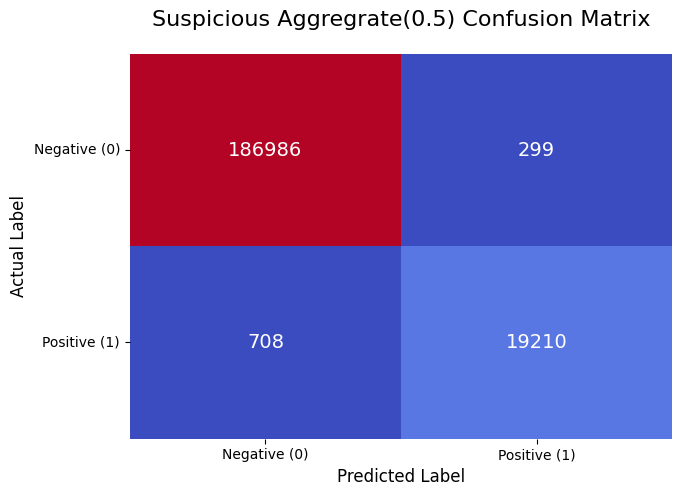

In [ ]:
majority_votes_sus_df = test_vector_search_results_grouped.agg({
    'train_sus': 'mean',
    'test_sus': 'mean'
})

majority_votes_sus_df['predicted_sus'] = (majority_votes_sus_df['train_sus'] >= 0.6).astype("Int64")

y_true = majority_votes_sus_df['test_sus']
y_pred = majority_votes_sus_df['predicted_sus']


tp = (((y_true == 1) & (y_pred == 1)).sum())
tn = (((y_true == 0) & (y_pred == 0)).sum())
fp = (((y_true == 0) & (y_pred == 1)).sum())
fn = (((y_true == 1) & (y_pred == 0)).sum())


calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Suspicious Aggregrate(0.6)')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Suspicious Aggregrate(0.4) Classification Metrics ---
Accuracy:    0.9946
Precision:   0.9596
Recall:      0.9853
F1-Score:    0.9723
MCC:         0.9694



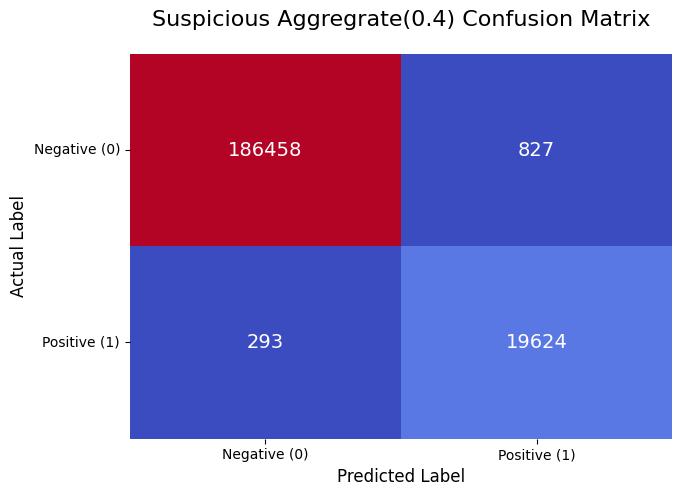

In [124]:
majority_votes_sus_df = test_vector_search_results_grouped.agg({
    'train_sus': 'mean',
    'test_sus': 'mean'
})

majority_votes_sus_df['predicted_sus'] = (majority_votes_sus_df['train_sus'] >= 0.4).astype("Int64")

y_true = majority_votes_sus_df['test_sus']
y_pred = majority_votes_sus_df['predicted_sus']


tp = (((y_true == 1) & (y_pred == 1)).sum())
tn = (((y_true == 0) & (y_pred == 0)).sum())
fp = (((y_true == 0) & (y_pred == 1)).sum())
fn = (((y_true == 1) & (y_pred == 0)).sum())


calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Suspicious Aggregrate(0.4)')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Suspicious Aggregrate(0.2) Classification Metrics ---
Accuracy:    0.9858
Precision:   0.8735
Recall:      0.9962
F1-Score:    0.9308
MCC:         0.9254



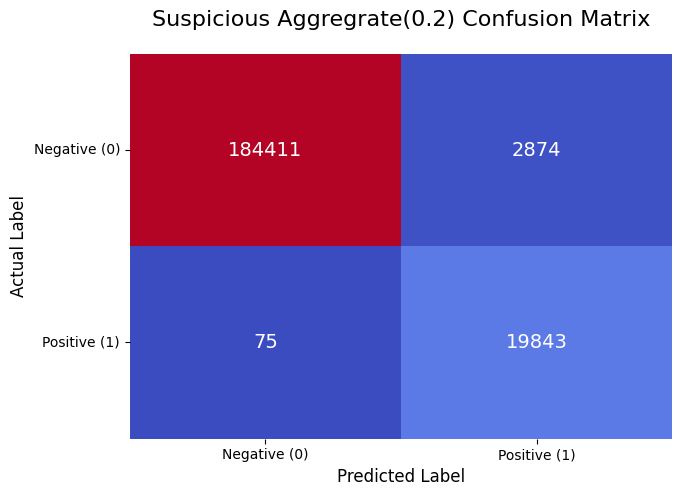

In [125]:
majority_votes_sus_df = test_vector_search_results_grouped.agg({
    'train_sus': 'mean',
    'test_sus': 'mean'
})

majority_votes_sus_df['predicted_sus'] = (majority_votes_sus_df['train_sus'] >= 0.2).astype("Int64")

y_true = majority_votes_sus_df['test_sus']
y_pred = majority_votes_sus_df['predicted_sus']


tp = (((y_true == 1) & (y_pred == 1)).sum())
tn = (((y_true == 0) & (y_pred == 0)).sum())
fp = (((y_true == 0) & (y_pred == 1)).sum())
fn = (((y_true == 1) & (y_pred == 0)).sum())


calculate_and_plot_metrics(tp=tp, tn=tn, fp=fp, fn=fn, plot_matrix=True, title_prefix='Suspicious Aggregrate(0.2)')

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Predictions (Evil >= 0.2 AND Sus > 0.6) Classification Metrics ---
Accuracy:    0.9993
Precision:   0.9721
Recall:      0.9807
F1-Score:    0.9764
MCC:         0.9760



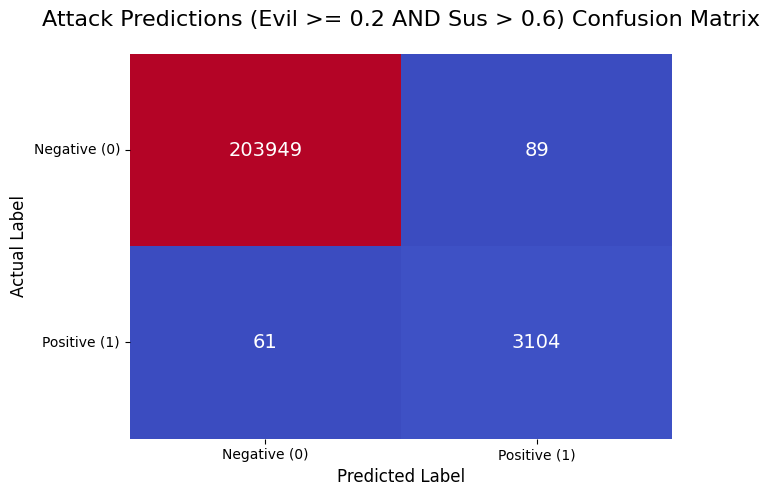

In [ ]:

majority_votes_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean',
    'train_sus': 'mean',
})

evil_condition = (majority_votes_df['train_evil'] >= 0.2)
sus_condition = (majority_votes_df['train_sus'] > 0.6)

majority_votes_df['predicted_evil'] = (evil_condition & sus_condition).astype("Int64")

y_true = majority_votes_df['test_evil']
y_pred = majority_votes_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()

calculate_and_plot_metrics(
    tp=tp, tn=tn, fp=fp, fn=fn,
    plot_matrix=True,
    title_prefix="Attack Predictions (Evil >= 0.2 AND Sus > 0.6)"
)

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Predictions (Evil >= 0.2 AND Sus >= 0.4) Classification Metrics ---
Accuracy:    0.9992
Precision:   0.9608
Recall:      0.9908
F1-Score:    0.9756
MCC:         0.9753



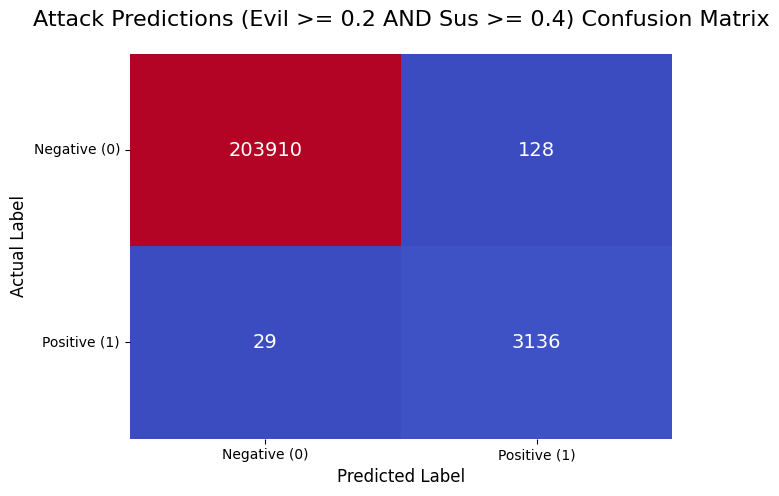

In [ ]:
majority_votes_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean',
    'train_sus': 'mean',
})

evil_condition = (majority_votes_df['train_evil'] >= 0.2)
sus_condition = (majority_votes_df['train_sus'] >= 0.4)

majority_votes_df['predicted_evil'] = (evil_condition & sus_condition).astype("Int64")

y_true = majority_votes_df['test_evil']
y_pred = majority_votes_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()

calculate_and_plot_metrics(
    tp=tp, tn=tn, fp=fp, fn=fn,
    plot_matrix=True,
    title_prefix="Attack Predictions (Evil >= 0.2 AND Sus >= 0.4)"
)

/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


/Users/jeffreysam/primary_env/lib/python3.13/site-packages/bigframes/core/compile/aggregate_compiler.py:167: FutureWarning: `Value.fillna` is deprecated as of v9.1; use fill_null instead
  return bq_sum.fillna(ibis_types.literal(0))


--- Attack Predictions (Evil >= 0.2 OR Sus >= 0.6) Classification Metrics ---
Accuracy:    0.9205
Precision:   0.1608
Recall:      0.9972
F1-Score:    0.2770
MCC:         0.3839



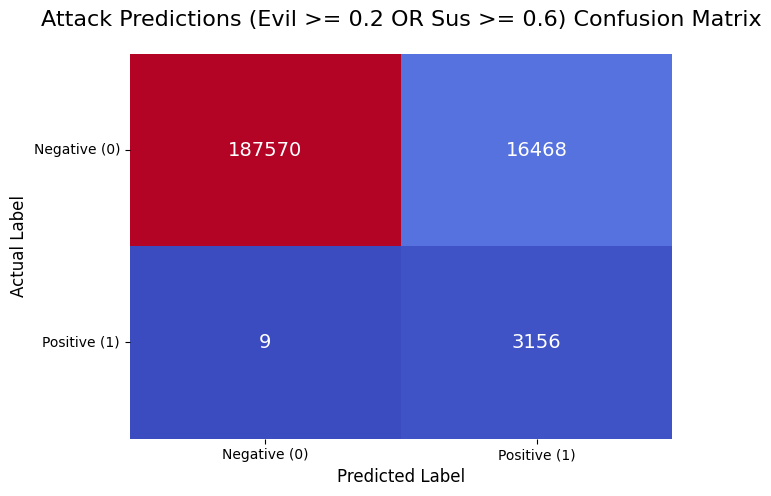

In [ ]:

majority_votes_df = test_vector_search_results_grouped.agg({
    'train_evil': 'mean',
    'test_evil': 'mean',
    'train_sus': 'mean',
})


evil_condition = (majority_votes_df['train_evil'] >= 0.2)
sus_condition = (majority_votes_df['train_sus'] >= 0.6)

majority_votes_df['predicted_evil'] = (evil_condition | sus_condition).astype("Int64")


y_true = majority_votes_df['test_evil']
y_pred = majority_votes_df['predicted_evil']

tp = ((y_true == 1) & (y_pred == 1)).sum()
tn = ((y_true == 0) & (y_pred == 0)).sum()
fp = ((y_true == 0) & (y_pred == 1)).sum()
fn = ((y_true == 1) & (y_pred == 0)).sum()


calculate_and_plot_metrics(
    tp=tp, tn=tn, fp=fp, fn=fn,
    plot_matrix=True,
    title_prefix="Attack Predictions (Evil >= 0.2 OR Sus >= 0.6)"
)